# Inversion for the relief of the Moho using tesseroids

In [1]:
%matplotlib inline
from __future__ import division
from fatiando.inversion.base import Misfit, CachedMethodPermanent, CachedMethod
from fatiando.inversion.regularization import Smoothness2D, TotalVariation2D, Damping
from fatiando.mesher import Tesseroid
from fatiando.vis import mpl, myv
from fatiando.gravmag import tesseroid
from fatiando import constants, utils, gridder
from scipy.optimize import minimize
import scipy.sparse
import numpy as np
import copy
import multiprocessing
import time
from IPython.display import Image
from cartopy import crs

In [2]:
# Get the number of cores in the computer to run the forward modeling in parallel
ncpu = multiprocessing.cpu_count()
ncpu

4

## Define a tesseroid relief mesh

There is a PrismRelief in Fatiando but we still need a TesseroidRelief. This is a mesh of tesseroids distributed along an area. Tesseroids have either the top of bottom fixed to a reference height. The other end ondulates along a relief.

In [3]:
class TesseroidRelief(object):
    def __init__(self, area, shape, relief, reference, props=None):
        assert shape[0]*shape[1] == relief.size
        assert len(area) == 4
        assert area[0] < area[1] and area[2] < area[3]
        self.area = area
        self.shape = shape
        x1, x2, y1, y2 = area
        ny, nx = shape
        self.spacing = ((x2 - x1)/nx, (y2 - y1)/ny)
        self._relief = relief
        self.reference = reference
        self.set_top_bottom()
        if props is None:
            self.props = {}
        else:
            self.props = props
        self._i = 0
    def set_top_bottom(self):
        self._top = self.relief.copy()
        self._bottom = self.reference*np.ones_like(self.relief)
        isbelow = self._top <= self.reference
        self._top[isbelow] = self.reference
        self._bottom[isbelow] = self.relief[isbelow]
    @property
    def top(self):
        return self._top
    @property
    def bottom(self):
        return self._bottom
    @property
    def relief(self):
        return self._relief
    @relief.setter
    def relief(self, z):
        assert z.size == self.size
        self._relief = z
        self.set_top_bottom()
    @property
    def size(self):
        return relief.size
    def __len__(self):
        return self.size
    def __iter__(self):
        self._i = 0
        return self
    def next(self):
        if self._i >= self.size:
            raise StopIteration
        cell = self.__getitem__(self._i)
        self._i += 1
        return cell
    def __getitem__(self, index):
        ny, nx = self.shape
        x1, x2, y1, y2 = self.area
        dx, dy = self.spacing
        j = index//nx
        i = index - j*nx
        w = x1 + i*dx
        e = w + dx
        s = y1 + j*dy
        n = s + dy
        top = self.top[index]
        bottom = self.bottom[index]
        props = {}
        for p in self.props:
            props[p] = self.props[p][index]
        cell = Tesseroid(w, e, s, n, top, bottom, props)
        return cell
    def copy(self, deep=False):
        if deep:
            other = copy.deepcopy(self)
        else:
            other = copy.copy(self)
        return other

Example of a TesseroidRelief:

In [4]:
shape = (30, 30)
# Make a regular grid inside an area
area = (-40, 40, 20, 60)
lon, lat, h = gridder.regular(area, shape, z=250e3)
# The model area is slightly larger because the points generated above are in the center of each cell.
dlon, dlat = gridder.spacing(area, shape)
modelarea = (area[0] - dlon/2, area[1] + dlon/2, area[2] - dlat/2, area[3] + dlat/2)
# Make a checkerboard relief undulating along the -35km height reference
f = 0.2
reference = -35e3
relief = 10e3*np.sin(f*lon)*np.cos(f*lat) + reference

In [5]:
# The density contrast is negative if the relief is below the reference
density = 600*np.ones_like(relief)
density[relief < reference] *= -1

In [6]:
sample_mesh = TesseroidRelief(modelarea, shape, relief, reference, {'density': density})

Plot the mesh in Mayavi:

In [7]:
def plot_result_3d(moho, fname):
    bounds = modelarea + (-20e3, -60e3)
    scale = (1, 1, 40) # Exaggerate the radial dimension
    datarange = np.abs([moho.props['density'].max(), moho.props['density'].min()]).max()
    scene = myv.figure(zdown=False)
    plot = myv.tesseroids(moho, 'density', scale=scale)
    plot.module_manager.scalar_lut_manager.show_legend = True
    plot.module_manager.scalar_lut_manager.lut_mode = 'RdYlBu'
    plot.module_manager.scalar_lut_manager.data_range = [-datarange, datarange]
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.minimum_size = np.array([1, 1])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position2 = np.array([ 0.13741855,  0.64385382])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.position = np.array([ 0.03303258,  0.07342193])
    plot.module_manager.scalar_lut_manager.scalar_bar_representation.maximum_size = np.array([100000, 100000])
    plot.module_manager.scalar_lut_manager.label_text_property.color = (0, 0, 0)
    plot.module_manager.scalar_lut_manager.title_text_property.color = (0, 0, 0)
    scene.scene.camera.position = [2252864.9143914036, -5202911.2574882135, 8495162.9722945951]
    scene.scene.camera.focal_point = [3135763.9476126051, 1056258.4985192744, 829277.18542720564]
    scene.scene.camera.view_angle = 30.0
    scene.scene.camera.view_up = [0.6164057832087273, 0.57367112225287575, 0.53939350563383837]
    scene.scene.camera.clipping_range = [783483.44437851617, 16078402.004277557]
    scene.scene.camera.compute_view_plane_normal()
    scene.scene.render()
    myv.savefig(fname)
    #myv.show()
    myv.mlab.close()
    return Image(filename=fname)    

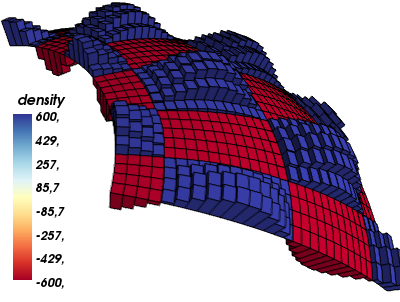

In [8]:
plot_result_3d(sample_mesh, 'example-mesh.png')

Calculate the gravity anomaly of this relief.

In [9]:
gz = tesseroid.gz(lon, lat, h, sample_mesh, njobs=ncpu)
gz = utils.contaminate(gz, 0.5)

<matplotlib.colorbar.Colorbar instance at 0x7f22b72a7f38>

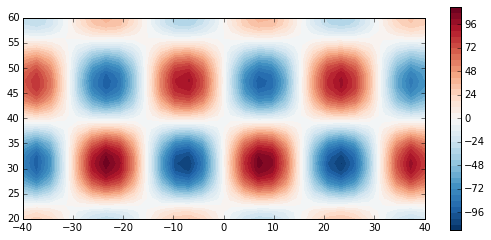

In [10]:
mpl.figure(figsize=(9, 4))
mpl.axis('scaled')
mpl.contourf(lon, lat, gz, shape, 40, cmap='RdBu_r')
mpl.colorbar()

## The Moho inversion method

Using the `fatiando.inversion` API. The inversion will be based on the method of Silva et al. 2014 to speedup computations. Silva et al. 2014 modify Bott's (1960) method. They show that Bott's method is a special case of the Gauss-Newton method

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + \left[\mathbf{A}^T \mathbf{A}\right]^{-1} \mathbf{A}^T [\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)]
$$

but with the Jacobian $\mathbf{A}$ approximated by a diagonal with 

$$
A_{ii} = 2\pi G \rho
$$. 

Silva et al. also implement a step size modification algorithm similar to Marquardt's method to speed up convergence.
 
Silva et al. don't actually solve the Gauss-Newton iterations to avoid the linear systems. However, all matrices involved are (very) sparse. The `fatiando.inversion` package can handle `scipy.sparse` matrices transparently so we'll use the standard inversion classes with sparse matrices for our implementation.

The step size modification algorithm can then be substituted by the Levemberg-Marquardt algorithm because solving the sparse linear systems is trivial and very fast.

We can further expand the method to cast Bott's method as a special case of the Steepest Descent algorithm. 
The step in the Steepest Descent method is

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - \nabla \Theta(\mathbf{p}^k) 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
$$

Bott's method would then be the special case of $\mathbf{A}$ being a diagonal matrix with 

$$
A_{ii} = \frac{1}{2(2 \pi G \rho_i)}.
$$

Both cases are implemented in the class `Moho` below. The Jacobian will be calculated appropriately, depending on the optimization method used.

In [11]:
class Moho(Misfit):
    def __init__(self, lon, lat, height, data, mesh, njobs=1, field='gz'):
        super(Moho, self).__init__(data=data, nparams=mesh.size, islinear=False, cache=False)
        assert mesh.size == data.size
        assert field in ['gz']
        self.lon = lon
        self.lat = lat
        self.height = height
        self.mesh = mesh.copy(deep=True)
        # Not caching the Jacobian and Hessian because
        # The Jacobian (and thus the Hessian) change depending
        # on the optimization method used. This will not be 
        # much of a problem because they take little time to build.
        self.predicted = CachedMethod(self, 'predicted')
        self.field = field
        self._kernel = getattr(tesseroid, field)
        self.njobs = njobs
        self.pool = None
        # The value that will go in the Jacobian
        self.set_step()
        self.kernel_kwargs = dict()
        
    def config_kernel(self, **kwargs):
        self.kernel_kwargs = kwargs
        return self
    
    def set_step(self, step=None):
        if step is None:
            self.step = utils.si2mgal(2*np.pi*constants.G*self.mesh.props['density'])
        else:
            self.step = step
        return self
        
    def fit(self):        
        if self.njobs > 1:
            self.pool = multiprocessing.Pool(self.njobs)
        super(Moho, self).fit()
        if self.pool is not None:
            self.pool.close()
            self.pool = None
        
    def predicted(self, p):
        mesh = self.mesh
        mesh.relief = p
        self.fix_density(mesh)
        njobs = self.njobs
        if self.pool is None:
            njobs = 1
        data = self._kernel(self.lon, self.lat, self.height, mesh, 
                            njobs=njobs, pool=self.pool, **self.kernel_kwargs)
        return data
    
    def fix_density(self, mesh):
        dens = mesh.props['density']
        should_b_pos = mesh.relief > mesh.reference
        dens[(should_b_pos) & (dens < 0)] *= -1
        dens[(~should_b_pos) & (dens > 0)] *= -1
        mesh.props['density'] = dens
        return mesh
    
    def jacobian(self, p):
        # Multiply by ones in case the step is a scalar
        step = np.ones(self.nparams)*self.step
        method = getattr(self, 'fit_method', None)
        if method is not None and method == 'steepest':
            step = 1/(2*step)
        jac = scipy.sparse.diags([np.abs(step)], [0]).tocsr()
        return jac
    
    def fmt_estimate(self, p):
        self.mesh.relief = p
        mesh = self.fix_density(self.mesh)
        return mesh

For a sythetic test, I'll try to invert the sample mesh above from noise corrupted data.

In [12]:
model = sample_mesh.copy(deep=True)
gz = tesseroid.gz(lon, lat, h, model, njobs=ncpu)
gz = utils.contaminate(gz, 2)

First, configure the inversion:

In [13]:
# Make a mesh
mesh = sample_mesh.copy(deep=True)
mesh.props['density'] = 600*np.ones(mesh.size)
# Create the solver (using all available CPU cores)
solver = Moho(lon, lat, h, gz, mesh, njobs=ncpu)
# Configure the optimization method
initial = np.ones(solver.nparams)*(mesh.reference - 30e3)
solver.config('steepest', initial=initial, tol=0.2, linesearch=False)

In [14]:
# Run the inversion and time the computation
t0 = time.time()
solver.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 8.40954184532 s


Plot the RMS per iteration to get an idea of the convergence of the method.

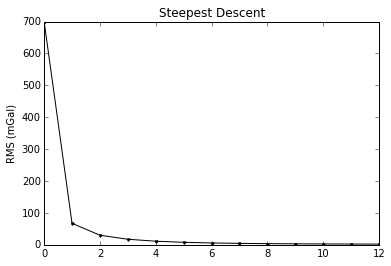

In [15]:
mpl.figure()
ax1 = mpl.subplot(111)
ax1.set_title(solver.stats_['method'])
rms = np.sqrt(solver.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')

Plot the data misfit and residuals

In [16]:
predicted = solver.predicted()
residuals = solver.residuals()
moho = solver.estimate_

/home/leo/bin/anaconda/lib/python2.7/site-packages/matplotlib/contour.py:381: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


array([-120., -100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,
         60.,   80.,  100.,  120.])

/home/leo/bin/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/home/leo/bin/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


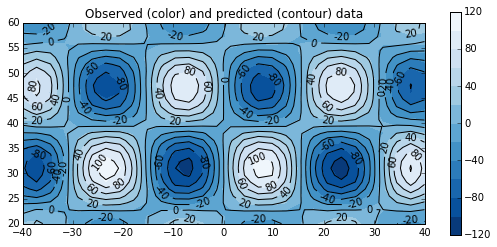

In [17]:
mpl.figure(figsize=(9, 4))
mpl.title('Observed (color) and predicted (contour) data')
mpl.axis('scaled')
levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='Blues_r')
mpl.colorbar()
mpl.contour(lon, lat, predicted, shape, levels)

Mean: 0.133456064357   std: 2.16209536131


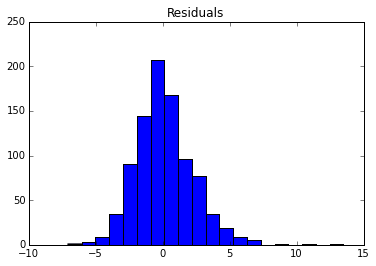

In [18]:
mpl.title('Residuals')
mpl.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

Map the estimated Moho depth.

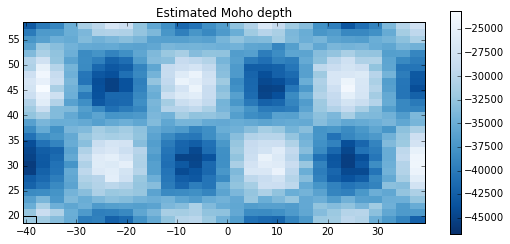

In [19]:
mpl.figure(figsize=(9, 4))
mpl.title("Estimated Moho depth")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, moho.relief, shape, cmap='Blues_r')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

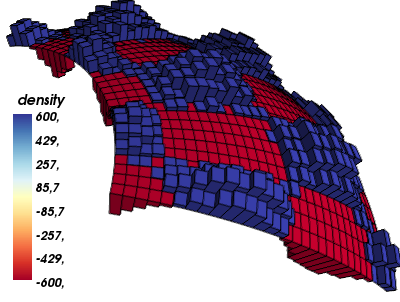

In [20]:
plot_result_3d(moho, 'simple-synthetic.png')

## Profile the inversion to see what is slow

I'll run the Python profiler (using the `%prun` IPython magic) to see where time is being spent in the inversion. I'll test the inversion by Gauss-Newton to see if solving the linear system has any impact on performance.

In [21]:
%prun -l 15 -q -T profiling.txt Moho(lon, lat, h, gz, mesh).config('newton', initial=initial, tol=0.2).fit()
%cat profiling.txt

 
*** Profile printout saved to text file u'profiling.txt'. 
         1914738 function calls (1811244 primitive calls) in 14.225 seconds

   Ordered by: internal time
   List reduced from 1454 to 15 due to restriction <15>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       13   11.963    0.920   14.184    1.091 tesseroid.py:288(_forward_model)
      200    0.190    0.001    0.193    0.001 core.py:127(stringz)
        8    0.103    0.013    0.103    0.013 executionengine.py:93(finalize_object)
   331889    0.082    0.000    0.082    0.000 {isinstance}
        8    0.081    0.010    0.081    0.010 passmanagers.py:26(run)
    11700    0.078    0.000    0.148    0.000 <ipython-input-3-67efef698e80>:53(__getitem__)
    49400    0.063    0.000    0.086    0.000 StringIO.py:208(write)
    11804    0.062    0.000    0.127    0.000 numpy_support.py:131(map_arrayscalar_type)
    11946    0.062    0.000    0.062    0.000 numpy_support.py:80(from_dtype)
53418/39549    

So it seems that all of the time is spent on forward modeling. This is not a bad thing because we can easily parallelize the forward modeling. The current inversion class does this by keeping a process pool openned and running the forward modeling on it. Keeping the pool is necessary to minimize the overhead of forking the processes evey time `predicted` is called.

## Smoothness regularization in Steepest Descent

Test that the inversion by Steepest Descent works with smoothness regularization. Adding smoothness, the step becomes

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k - [\nabla \Theta(\mathbf{p}^k) + \mu \nabla \Phi_{smooth}(\mathbf{p}^k)]
$$

$$
\mathbf{p}^{k+1} 
= \mathbf{p}^k + 2\mathbf{A}^T \left[\mathbf{d}^o - \mathbf{d}(\mathbf{p}^k)\right]
- \mu 2 \mathbf{R}^T \mathbf{R} \mathbf{p}^k
$$

This is the approach adopted by Santos et al. (2015) (though they fail to mention it in the article).

In [22]:
smooth = solver + 5e-3*Smoothness2D(mesh.shape)
smooth.config('steepest', initial=initial, tol=0.01, maxit=30, linesearch=False)
t0 = time.time()
smooth.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 8.22349905968 s


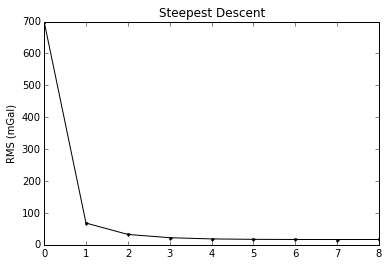

In [23]:
mpl.figure()
ax1 = mpl.subplot(111)
rms = np.sqrt(smooth.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_title(smooth.stats_['method'])

In [24]:
predicted = smooth[0].predicted()
residuals = smooth[0].residuals()
moho = smooth.estimate_

array([-120., -100.,  -80.,  -60.,  -40.,  -20.,    0.,   20.,   40.,
         60.,   80.,  100.,  120.])

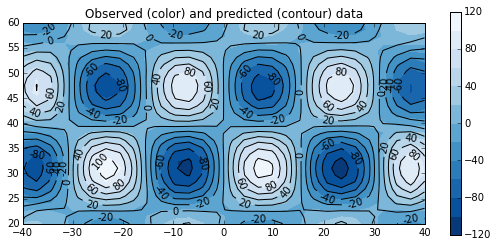

In [25]:
mpl.figure(figsize=(9, 4))
mpl.title('Observed (color) and predicted (contour) data')
mpl.axis('scaled')
levels = mpl.contourf(lon, lat, gz, shape, 12, cmap='Blues_r')
mpl.colorbar()
mpl.contour(lon, lat, predicted, shape, levels)

Mean: 0.370790750865   std: 3.61899821994


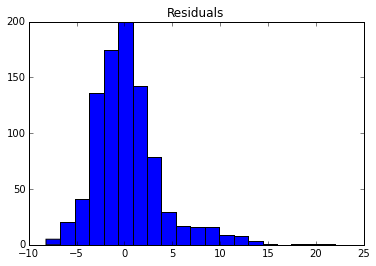

In [26]:
mpl.title('Residuals')
mpl.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

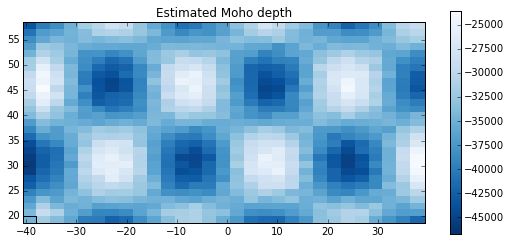

In [27]:
mpl.figure(figsize=(9, 4))
mpl.title("Estimated Moho depth")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, moho.relief, shape, cmap='Blues_r')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

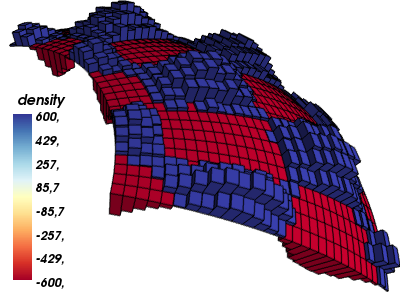

In [28]:
plot_result_3d(moho, 'smooth-synthetic.png')

**Notice that even when underfitting the data, the solution is still not properly smooth.** 
So it seems that using only the gradient of the smoothness regularization is not enough to fully smooth the solution. The results in Santos et al 2015 are smooth, though. Maybe that's because they start out with a regularized solution from the start.

## Using Gauss-Newton to impose smoothness

Let's see if using Gauss-Newton (and consequently solving the sparse linear systems) improves the smoothness regularization.

In [29]:
smooth2 = solver + 5e-4*Smoothness2D(mesh.shape)
smooth2.config('newton', initial=initial, tol=0.1)
t0 = time.time()
smooth2.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 13.7636361122 s


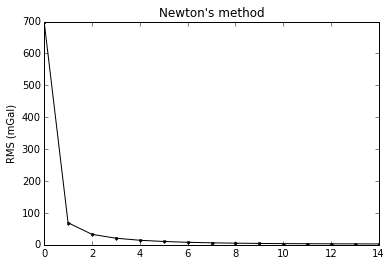

In [30]:
mpl.figure()
ax1 = mpl.subplot(111)
rms = np.sqrt(smooth2.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_title(smooth2.stats_['method'])

In [31]:
predicted = smooth2[0].predicted()
residuals = smooth2[0].residuals()
moho = smooth2.estimate_

Mean: 0.0734644512844   std: 2.33118193502


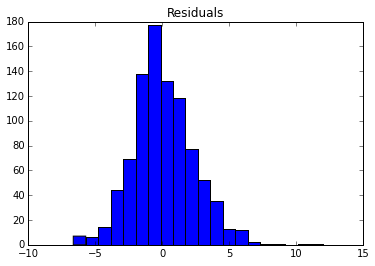

In [32]:
mpl.title('Residuals')
mpl.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

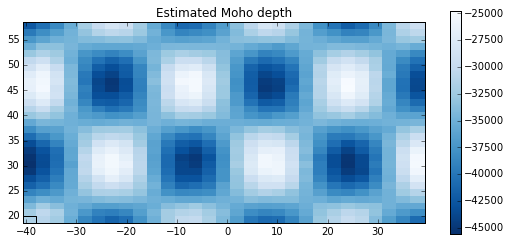

In [33]:
mpl.figure(figsize=(9, 4))
mpl.title("Estimated Moho depth")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, moho.relief, shape, cmap='Blues_r')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

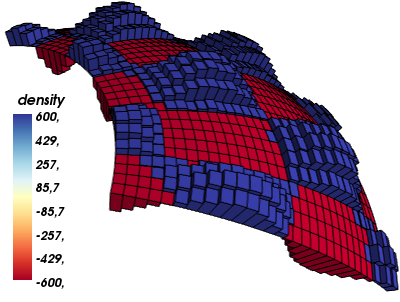

In [34]:
plot_result_3d(moho, 'smooth-gauss-newton-synthetic.png')

So using Gauss-Newton optimization we can get proper smoothing of the solution while still fitting the data. 

The computation time is larger because of the extra iterations in Gauss-Newton. If we calculate the time per iteration, for Steepest Descent we have:

In [35]:
7.9/7 # Computation time / n. iterations

1.1285714285714286

and for Gauss-Newton:

In [36]:
14.1/14

1.0071428571428571

So there is no extra cost from using Gauss-Newton and solving the sparse linear system.

## Inverting a Moho with laterally varying density

Lets see if the method for a Moho with a varying density contrast between crust and mantle.

In [37]:
model_varied = sample_mesh.copy(deep=True)
vardensity = -300*utils.gaussian2d(lon, lat, 50, 30, x0=-20, y0=50, angle=-45) + 600
isabove = model_varied.relief > model_varied.reference
vardensity[isabove] *= -1
model_varied.props['density'] = vardensity

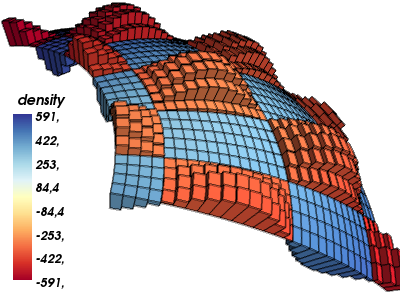

In [38]:
plot_result_3d(model_varied, 'variable-density-model.png')

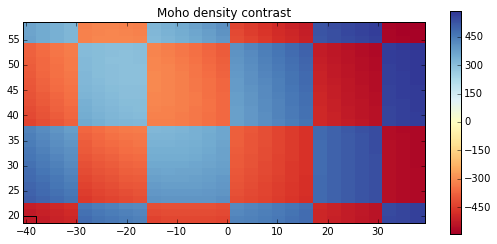

In [39]:
mpl.figure(figsize=(9, 4))
mpl.title("Moho density contrast")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, model_varied.props['density'], shape, cmap='RdYlBu')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

In [40]:
gz = utils.contaminate(tesseroid.gz(lon, lat, h, model_varied, njobs=ncpu), 2)

<matplotlib.colorbar.Colorbar instance at 0x7f22b64af950>

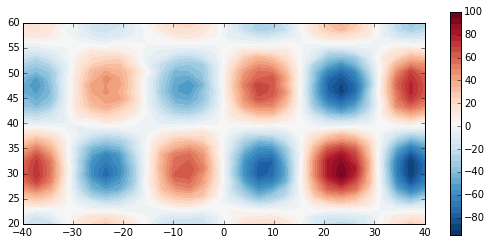

In [41]:
mpl.figure(figsize=(9, 4))
mpl.axis('scaled')
mpl.contourf(lon, lat, gz, shape, 40, cmap='RdBu_r')
mpl.colorbar()

In [42]:
mesh = model_varied.copy(deep=True)
vardens = Moho(lon, lat, h, gz, mesh, njobs=ncpu) + 5e-4*Smoothness2D(mesh.shape)
vardens.config('newton', initial=initial, tol=0.1) 
t0 = time.time()
vardens.fit()
dt = time.time() - t0
print("Time it took: {} s".format(dt))

Time it took: 14.7003118992 s


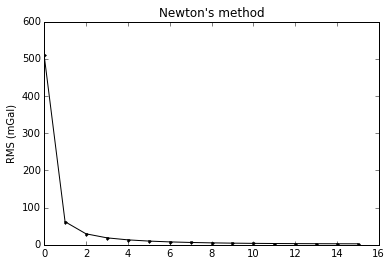

In [43]:
mpl.figure()
ax1 = mpl.subplot(111)
rms = np.sqrt(vardens.stats_['objective'])/np.sqrt(solver.ndata)
ax1.plot(rms, '.k-')
ax1.set_ylabel('RMS (mGal)')
ax1.set_title(vardens.stats_['method'])

In [44]:
predicted = vardens[0].predicted()
residuals = vardens[0].residuals()
moho = vardens.estimate_

Mean: 0.043783508789   std: 2.25401189507


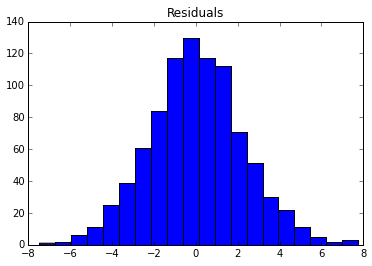

In [45]:
mpl.title('Residuals')
mpl.hist(residuals, bins=20)
print('Mean: {}   std: {}'.format(residuals.mean(), residuals.std()))

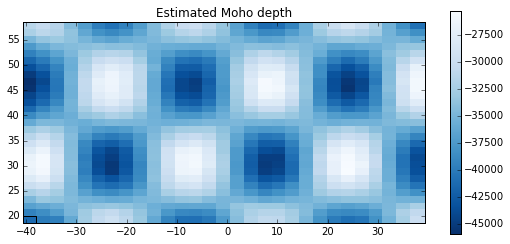

In [46]:
mpl.figure(figsize=(9, 4))
mpl.title("Estimated Moho depth")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, moho.relief, shape, cmap='Blues_r')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

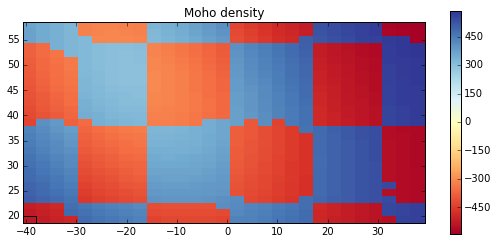

In [47]:
mpl.figure(figsize=(9, 4))
mpl.title("Moho density")
mpl.axis('scaled')
mpl.pcolor(lon - dlon/2, lat - dlat/2, moho.props['density'], shape, cmap='RdYlBu')
mpl.colorbar()
mpl.square(model[0].get_bounds()[:4])

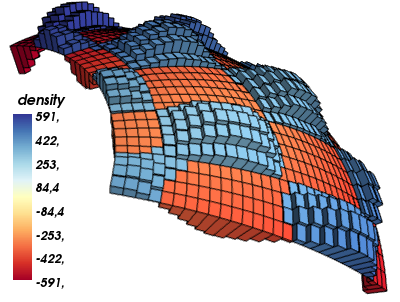

In [48]:
plot_result_3d(moho, 'variable-density-result.png')